In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib widget
from bouter import FreelySwimmingExperiment
from bouter import ASSETS_PATH
from bouter.utilities import extract_segments_above_threshold
from math import isnan
import json
import glob
from pathlib import Path
import os

sns.set(style='ticks', palette='deep')
%load_ext autoreload
%autoreload 2

In [2]:
#this is the path where all fish folders are
path_dir = Path(r'')

In [2]:
#this is a data frame where i will store variables from each fish, and use them for population statistics later
all_fish_df = pd.DataFrame (columns=['fish id', 'genotype', 'age', 'comments', 'n_left_pause', 'n_left_stim_r', 'n_left_stim_l',
                                 'n_right_pause','n_right_stim_r', 'n_right_stim_l','n_forward_pause','n_forward_stim_r',
                                 'n_forward_stim_l', 'fr_c_stim_r','fr_c_stim_l','angles_pause', 'angles_stim_r', 'angles_stim_l',
                                 'mean_bdur_pause', 'mean_bdur_stim', 'mean_ibi_pause', 'mean_ibi_stim', 'mean_vel',
                                 'mean_disp_pause', 'mean_disp_stim'])

Working on /Users/elenadragomir/Documents/ucl_research/zfhx4_omr/test/221103_f8
injected


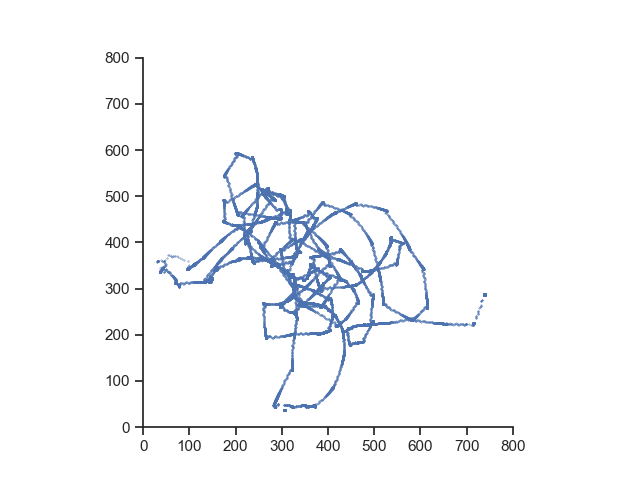

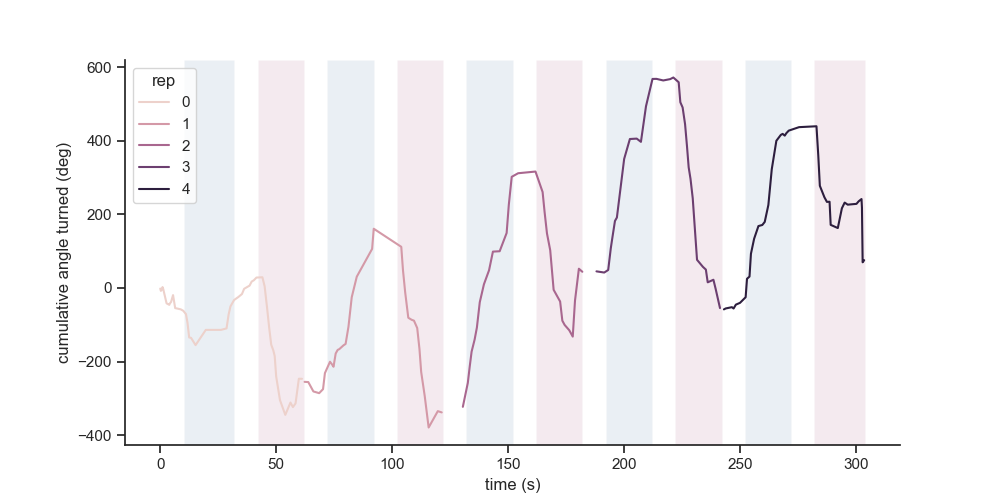

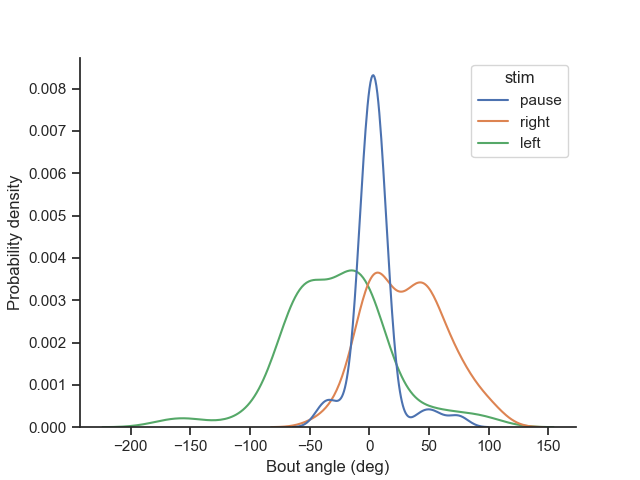

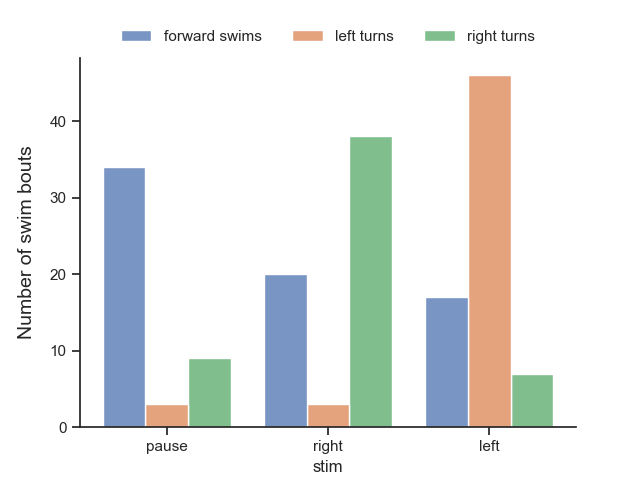

Working on /Users/elenadragomir/Documents/ucl_research/zfhx4_omr/test/221103_f7
wt


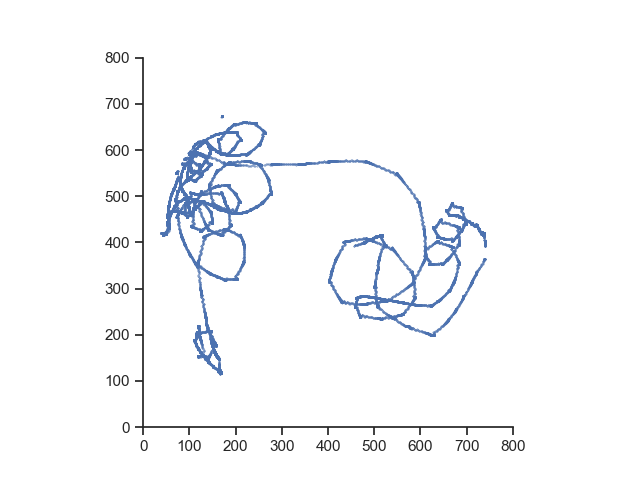

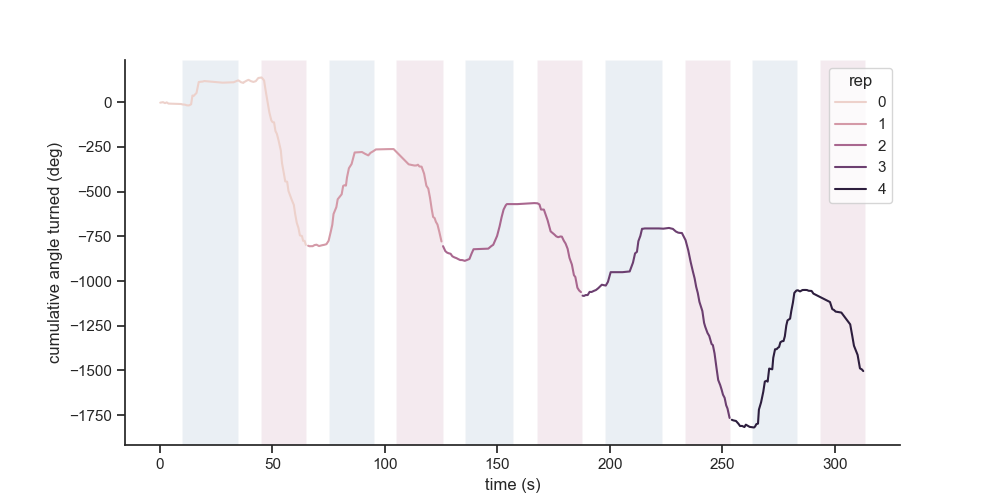

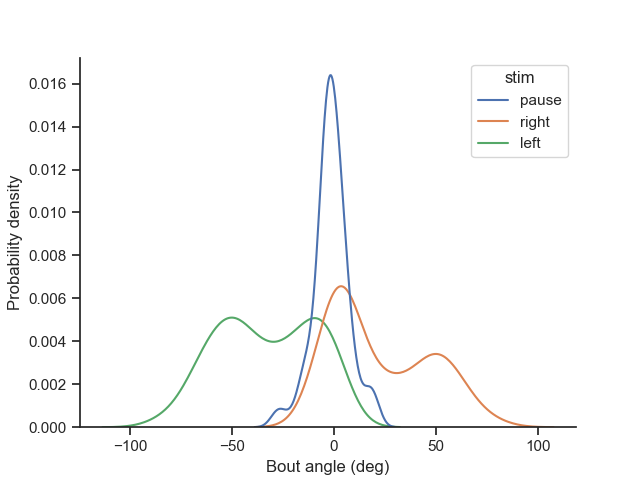

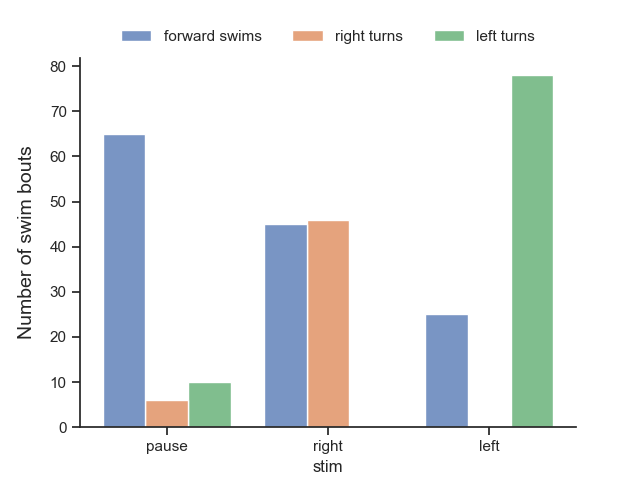

Working on /Users/elenadragomir/Documents/ucl_research/zfhx4_omr/test/221103_f9
wt


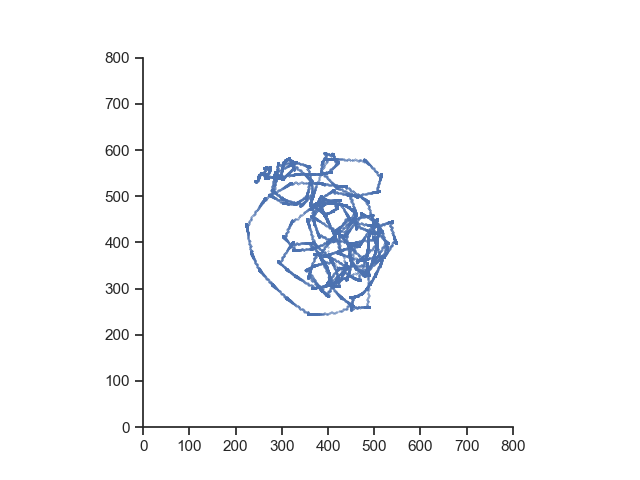

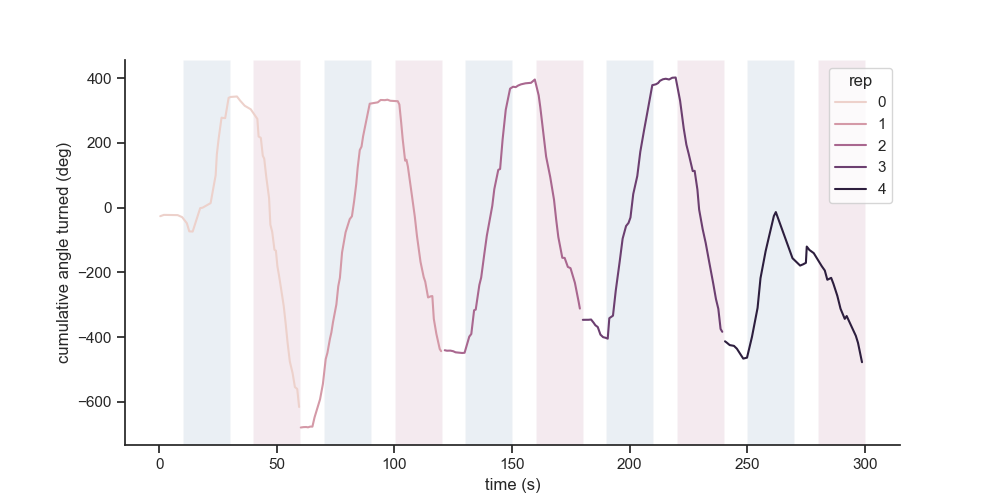

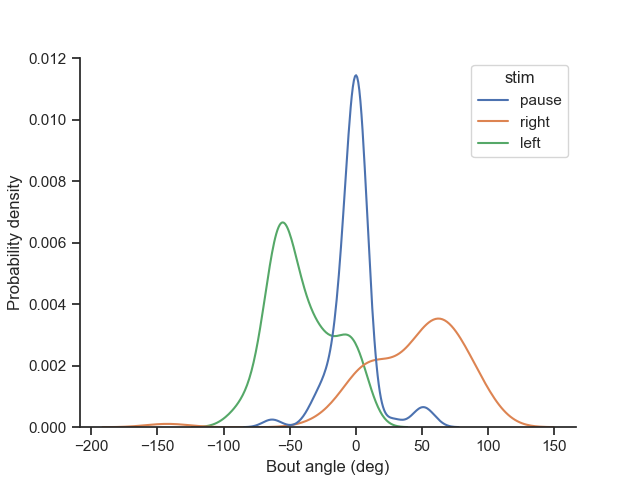

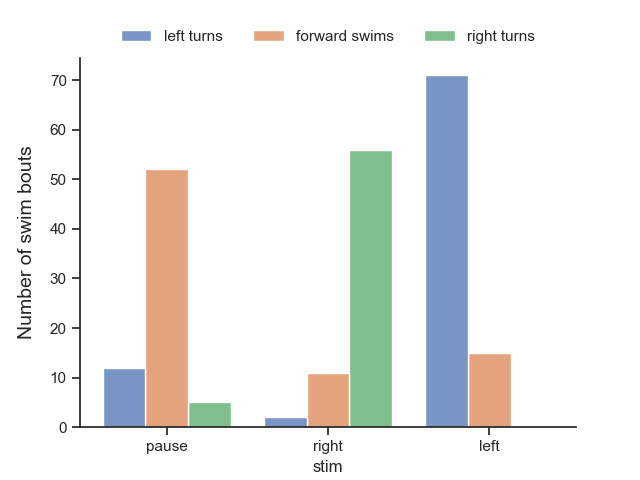

In [4]:
#going through every fish, computing various parameters and adding them to the 'fish pool' data frame
for exp_index, experiment_path in enumerate (list(path_dir.glob("*_f*"))):
    if not os.path.exists(str(experiment_path)+'/trajectories.jpeg'): #check if fish was already analyzed; analyze only if "all_trials" file is not already in fish folder       
        print('Working on ' + str(experiment_path))
        
        exp = FreelySwimmingExperiment(experiment_path)
        print(exp['general']['animal']['genotype'])
        #plotting changes in x y position for each fish
        fig, ax = plt.subplots()
        ax.set_aspect(1)
        ax.scatter(exp.behavior_log.f0_x, exp.behavior_log.f0_y, s=0.1)
        ax.set_xlim(0,800)
        ax.set_ylim(0, 800)
        sns.despine()
        plt.show()
        plt.savefig(str(experiment_path) +'/trajectories.jpeg', bbox_inches='tight')
        
        #extracting bouts
        exp.reconstruct_missing_segments(continue_curvature=4)
        exp.get_bouts()
        bouts=exp.get_bout_properties()
        bouts['theta_abs']=(bouts['theta_end']-bouts['theta_start'])*57.32 # positive theta_abs means right turns
    
    
        #classify bouts according to stimulus and rep number
        bouts['rep']=0
        bouts['stim']='pause'
        t_start_ls=[]
        t_start_rs=[]
        t_stop_ls=[]
        t_stop_rs=[]
        
        for rep in range (len(exp["stimulus"]["log"])):
            mask = (bouts['t_start'] >= exp["stimulus"]["log"][rep]['t_start']) & (bouts['t_start'] < exp["stimulus"]["log"][rep]['t_stop'])
            bouts.loc[mask, 'rep'] = rep

            stim_r = exp.stimulus_log.loc[(exp.stimulus_log['t'] >= exp["stimulus"]["log"][rep]['t_start']) &
                    (exp.stimulus_log['t'] < exp["stimulus"]["log"][rep]['t_stop']) &
                    (exp.stimulus_log['moving_gratings_current_phase'] == 1)]

            t_start_r=stim_r['t'].iloc[0]
            t_stop_r=stim_r['t'].iloc[-1]
            mask = (bouts['t_start'] >= t_start_r) & (bouts['t_start'] < t_stop_r)
            bouts.loc[mask, 'stim'] = 'right'
            t_start_rs.append(t_start_r)
            t_stop_rs.append(t_stop_r)

            stim_l = exp.stimulus_log.loc[(exp.stimulus_log['t'] >= exp["stimulus"]["log"][rep]['t_start']) &
                    (exp.stimulus_log['t'] < exp["stimulus"]["log"][rep]['t_stop']) &
                    (exp.stimulus_log['moving_gratings_current_phase'] == 3)]
            t_start_l=stim_l['t'].iloc[0]
            t_stop_l=stim_l['t'].iloc[-1]
            mask = (bouts['t_start'] >= t_start_l) & (bouts['t_start'] < t_stop_l)
            bouts.loc[mask, 'stim'] = 'left'
            t_start_ls.append(t_start_l)
            t_stop_ls.append(t_stop_l)
            
            
        #plotting cumulative angle turned throughout the experiment
        plt.figure(figsize=(10,5))
        sns.lineplot(data=bouts, x='t_start', y=np.nancumsum(bouts['theta_abs']), hue='rep')
        for i in range(len(t_start_rs)):
            plt.axvspan(t_start_rs[i], t_stop_rs[i], facecolor='#3A6397', alpha=0.1)
            plt.axvspan(t_start_ls[i], t_stop_ls[i], facecolor='#973A67', alpha=0.1)
        sns.despine()
        plt.xlabel('time (s)')
        plt.ylabel('cumulative angle turned (deg)')
        plt.show()
        plt.savefig(str(experiment_path) +'/cummulative_angles.jpeg', bbox_inches='tight')
        
        #plotting angle distributions
        plt.figure()
        sns.kdeplot(data=bouts, x='theta_abs', hue='stim')
        plt.xlabel('Bout angle (deg)')
        plt.ylabel('Probability density')
        sns.despine()
        plt.show()
        plt.savefig(str(experiment_path) +'/angle_distributions.jpeg', bbox_inches='tight')
        
        #get number of left/right turns per stim
        bouts['bout_classifier'] = pd.Series(index=bouts.index, dtype=object)
        mask = (bouts['theta_abs'] > 10) & (bouts['theta_abs'] < 100)
        bouts.loc[mask, 'bout_classifier'] = 'right turns'
        
        mask = (bouts['theta_abs'] < -10) & (bouts['theta_abs'] > -100)
        bouts.loc[mask, 'bout_classifier'] = 'left turns'
        
        mask = (bouts['theta_abs'] >= -10) & (bouts['theta_abs'] <= 10)
        bouts.loc[mask, 'bout_classifier'] = 'forward swims'

        #plotting number of turns
        fig, ax= plt.subplots()
        ax=sns.histplot(x="stim", hue="bout_classifier", data=bouts, multiple="dodge", shrink=.8)
        sns.despine()
        sns.move_legend(ax, "lower center", bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False,)
        plt.ylabel('Number of swim bouts', labelpad=10, size=14)
        plt.show()
        plt.savefig(str(experiment_path) +'/bout_numbers.jpeg', bbox_inches='tight')
    
        
        #getting the angles in each stim
        angles_pause = bouts.loc[bouts['stim'] == 'pause', 'theta_abs'].to_list()
        angles_right = bouts.loc[bouts['stim'] == 'right', 'theta_abs'].to_list()
        angles_left = bouts.loc[bouts['stim'] == 'left', 'theta_abs'].to_list()
        
        #calculating number of directional turns per each stim
        n_right_stim_r=len(bouts.loc[(bouts['bout_classifier']=='right turns') & (bouts['stim']=='right')])
        n_left_stim_r=len(bouts.loc[(bouts['bout_classifier']=='left turns') & (bouts['stim']=='right')])
        n_forw_stim_r=len(bouts.loc[(bouts['bout_classifier']=='forward swims') & (bouts['stim']=='right')])
        correct_stim_r=n_right_stim_r/(n_right_stim_r+n_left_stim_r+n_forw_stim_r)

        n_right_stim_l=len(bouts.loc[(bouts['bout_classifier']=='right turns') & (bouts['stim']=='left')])
        n_left_stim_l=len(bouts.loc[(bouts['bout_classifier']=='left turns') & (bouts['stim']=='left')])
        n_forw_stim_l=len(bouts.loc[(bouts['bout_classifier']=='forward swims') & (bouts['stim']=='left')])
        correct_stim_l=n_left_stim_l/(n_right_stim_l+n_left_stim_l+n_forw_stim_l)

        n_right_stim_p=len(bouts.loc[(bouts['bout_classifier']=='right turns') & (bouts['stim']=='pause')])
        n_left_stim_p=len(bouts.loc[(bouts['bout_classifier']=='left turns') & (bouts['stim']=='pause')])
        n_forw_stim_p=len(bouts.loc[(bouts['bout_classifier']=='forward swims') & (bouts['stim']=='pause')])
        
        #bout duration:
        bout_duration_pause=[]
        bout_duration_stim=[]
        
        #average interbout interval
        ibi_pause=[]
        ibi_stim=[]
        
        #mean bout displacement 
        disps_bp=[]
        disps_b_stim=[]
        
        bp=bouts[bouts['stim']=='pause']
        bl=bouts[bouts['stim']=='left']
        br=bouts[bouts['stim']=='right']
        b_stim=pd.concat([bl, br])

        for i in range (len(bp)-1):
            bout_duration_pause.append(bp.t_end.iloc[i]-bp.t_start.iloc[i])
            
            if bp.t_start.iloc[i+1]-bp.t_start.iloc[i]<10 and bp.t_start.iloc[i+1]-bp.t_start.iloc[i]>0:
                ibi_pause.append(bp.t_start.iloc[i+1]-bp.t_start.iloc[i])
                
            disps_bp.append(np.sqrt((bp['x_end'].iloc[i]-bp['x_start'].iloc[i])**2+
                                       (bp['y_end'].iloc[i]-bp['y_start'].iloc[i])**2))

        for j in range (len(b_stim)-1):
            bout_duration_stim.append(b_stim.t_end.iloc[j]-b_stim.t_start.iloc[j])
            
            if b_stim.t_start.iloc[j+1]-b_stim.t_start.iloc[j]<10 and b_stim.t_start.iloc[j+1]-b_stim.t_start.iloc[j]>0:
                ibi_stim.append(b_stim.t_start.iloc[j+1]- b_stim.t_start.iloc[j])
                
            disps_b_stim.append(np.sqrt((b_stim['x_end'].iloc[j]-b_stim['x_start'].iloc[j])**2+
                                       (b_stim['y_end'].iloc[j]-b_stim['y_start'].iloc[j])**2))    

        mean_bdur_pause=np.mean(bout_duration_pause)
        mean_bdur_stim=np.mean(bout_duration_stim)

        mean_ibi_pause=np.mean(ibi_pause)
        mean_ibi_stim=np.mean(ibi_stim)

        mean_disp_pause=np.nanmean(disps_bp)
        mean_disp_stim=np.nanmean(disps_b_stim)
        
        
        #computing velocity
        velocities_df=exp.compute_velocity()
        #breaking the velocitites df into the 4 stim periods
        bouts_v, cont1 = extract_segments_above_threshold(velocities_df.values, threshold=1, min_length=15, min_between=5)
    
        #calculating mean vel only within bout times
        vel_mean=[]
        for i in range(len(bouts_v)):
            vel_mean.append(velocities_df.iloc[bouts_v[i][0]:bouts_v[i][1], :].values.mean())
        mean_vel= np.mean(vel_mean)


        #adding variables to fish_df
        all_fish_df.loc[exp_index] = exp.fish_id, exp['general']['animal']['genotype'], exp['general']['animal']['age'],\
        exp['general']['animal']['comments'], n_left_stim_p, n_left_stim_r, n_left_stim_l, n_right_stim_p, n_right_stim_r,\
        n_right_stim_l, n_forw_stim_p, n_forw_stim_r, n_forw_stim_l, correct_stim_r, correct_stim_l, angles_pause, angles_right,\
        angles_left, mean_bdur_pause, mean_bdur_stim, mean_ibi_pause,mean_ibi_stim, mean_vel, mean_disp_pause, mean_disp_stim
        
        
#saving the fish df to a json file (that can be used later for population stats)
#all_fish_df.to_json(str(path_dir) +'/fish_pool.json') 
